In [1]:
import numpy as np
from math import e
import scipy
from scipy import linalg
from scipy.spatial import distance
import matplotlib.pyplot as plt
from autograd import grad as nabla
from autograd import hessian

In [2]:
#################################### Functions ####################################
# make_list
def make_list(n):
    return [[] for i in range(n)]

# 最急降下法(1step) (1-1)
def steep_dec(funcf, curX, eps):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    # 更新則
    new_X = curX - eps * grd
    return new_X

def steep_dec_armijo(funcf, curX, beta, gamma):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    # 直線探索 (Armijoのルール)
    l_k = 1
    while True:
        lft = funcf(curX + beta**l_k * (-1) * grd) - funcf(curX)
        rit = gamma * beta**l_k * grd.T @ ((-1) * grd)
        if lft > rit:
            l_k += 1
        else:
            eps = beta**l_k
            break
        # 更新則
    new_X = curX - eps * grd
    return new_X

# モーメンタム法(1step) (1-2)
def momentum(funcf, curX, prevX, eps, p):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    # 更新則
    new_X = curX - eps * grd + p * (curX - prevX)
    return new_X

# ニュートン法(1step) (1-3)
def newton(funcf, curX):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    # 現在のHessianを求める
    hesse = hessian(funcf)(curX).reshape((curX.size, curX.size))
    new_X = curX - np.linalg.inv(hesse) @ grd
    return new_X

# Adagrad
def adagrad_iteration(funcf, curX, eps, smallvalue, gradlist):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    gradlist.append(grd)
    upd_vec = []
    # 各成分ごとに
    for i in range(curX.size):
        # 分子: epsilon * (現在の勾配の第i成分)
        val = eps * grd[i][0]
        smm = 0
        # 分母: 過去の勾配の第i成分の二乗和の平方根
        for j in range(len(gradlist)):
            smm += gradlist[j][i][0]**2
        pos = np.sqrt(smm + smallvalue)     # 0で割らないようにsmallvalueを加える
        upd_vec.append(val / pos)
    upd_vec = np.array(upd_vec).reshape(curX.shape)
    # 更新則
    new_X = curX - upd_vec
    return new_X, gradlist

# RMSprop
def rmsprop_iteration(funcf, curX, eps, smallvalue, rho, vlist):
    # 現在の勾配を求める
    grd = nabla(funcf)(curX).reshape(curX.shape)
    # vの更新
    if len(vlist) == 0:
        curV = (1 - rho) * (grd * grd)              # grd * grd: Hadamard積
    else:
        prevV = vlist[-1]
        curV = rho * prevV + (1 - rho) * (grd * grd)
    vlist.append(curV)
    upd_vec = []
    # 各成分ごとに
    for i in range(curX.size):
        # 分子: epsilon * (現在の勾配の第i成分)
        val = eps * grd[i][0]
        smm = 0
        # 分母: (v + smallvalue)の平方根
        pos = np.sqrt(curV[i] + smallvalue)    # 0で割らないようにsmallvalueを加える
        upd_vec.append(val / pos)
    upd_vec = np.array(upd_vec).reshape(curX.shape)
    # 更新則
    new_X = curX - upd_vec
    return new_X, vlist



# 更新
def iteration_upd(funcf, Xinit, Maxitr, eps, smallvalue, p, rho, beta, gamma, keyword):
    lstX = [Xinit]; lstfX = [funcf(Xinit)]; gradlist = []; vlist = []
    itr = Maxitr; flag = 1
    for i in range(1, Maxitr):
        # 現在のx
        curX = lstX[-1]
        if len(lstX) == 1:
            prevX = lstX[-1]
        else:
            prevX = lstX[-2]
        # 1ステップ後のx
        if keyword == "steepest":
            newX = steep_dec(funcf, curX, eps)
        elif keyword == "steepest_lin":
            newX = steep_dec_armijo(funcf, curX, beta, gamma)
        elif keyword == "newton":
            newX = newton(funcf, curX)
        elif keyword == "momentum":
            newX = momentum(funcf, curX, prevX, eps, p)
        elif keyword == "adagrad":
            newX, gradlist = adagrad_iteration(funcf, curX, eps, smallvalue, gradlist)
        elif keyword == "rmsprop":
            newX, vlist = rmsprop_iteration(funcf, curX, eps, smallvalue, rho, vlist)
        else:
            print("Miss the keyword")
            return [], []
        # 現在と1ステップ後の距離
        dst = distance.euclidean(newX, curX)
        if dst < 1e-6 and flag == 1:
                # 収束までの繰り返し数の表示
                print("Converse, roop: %d"%i)
                itr = i; flag = 0
        if dst < 1e+5:
            lstX.append(newX)
            lstfX.append(funcf(newX))
        # 発散したら表示する
        else:
            print("Diverse!")
            break
    return lstX, lstfX, itr

In [3]:
#################################### Test ####################################
## function f1
f1 = lambda X: (X[0]**2 - 2*X[0]*X[1] + X[1]**4/4 - X[1]**3/3)[0]
def f1fig(X1, X2):
    return X1**2 - 2*X1*X2 + X2**4/4 - X2**3/3
X0 = np.array([
    [-0.5],
    [1.5]
])

In [4]:
## execute iteration
Xlst_s, flst_s, itr_s = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-2, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "steepest")
Xlst_sl, flst_sl, itr_sl = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-2, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "steepest_lin")
Xlst_m, flst_m, itr_m = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-2, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "momentum")
Xlst_n, flst_n, itr_n = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-2, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "newton")
Xlst_a, flst_a, itr_a = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-1, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "adagrad")
Xlst_r, flst_r, itr_r = iteration_upd(f1, X0, Maxitr = 500, eps = 1e-2, smallvalue = 1e-7, p = 0.9, rho = 0.9, beta = 0.1, gamma = 1e-5, keyword = "rmsprop")

Converse, roop: 90
Converse, roop: 235
Converse, roop: 6


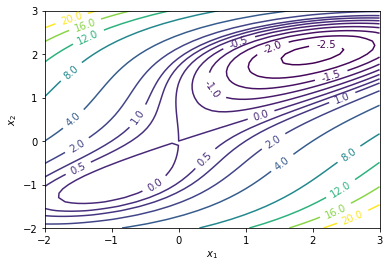

In [5]:
## draw function f1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
x1 = np.linspace(-2, 3, 51)
x2 = np.linspace(-2, 3, 51)
X1_grid, X2_grid = np.meshgrid(x1, x2)
value = f1fig(X1_grid, X2_grid)
cont = ax.contour(X1_grid, X2_grid, value, levels=[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0])
cont.clabel(fmt='%1.1f')
plt.show()

In [6]:
# get list of data
Xval_s = make_list(X0.size)
Xval_sl = make_list(X0.size)
Xval_m = make_list(X0.size)
Xval_n = make_list(X0.size)
Xval_a = make_list(X0.size)
Xval_r = make_list(X0.size)

for i in range(len(Xlst_s)):
    for j in range(Xlst_s[i].size):
        Xval_s[j].append(Xlst_s[i][j])
for i in range(len(Xlst_sl)):
    for j in range(Xlst_sl[i].size):
        Xval_sl[j].append(Xlst_sl[i][j])
for i in range(len(Xlst_m)):
    for j in range(Xlst_m[i].size):
        Xval_m[j].append(Xlst_m[i][j])
for i in range(len(Xlst_n)):
    for j in range(Xlst_n[i].size):
        Xval_n[j].append(Xlst_n[i][j])
for i in range(len(Xlst_a)):
    for j in range(Xlst_a[i].size):
        Xval_a[j].append(Xlst_a[i][j])
for i in range(len(Xlst_r)):
    for j in range(Xlst_r[i].size):
        Xval_r[j].append(Xlst_r[i][j])

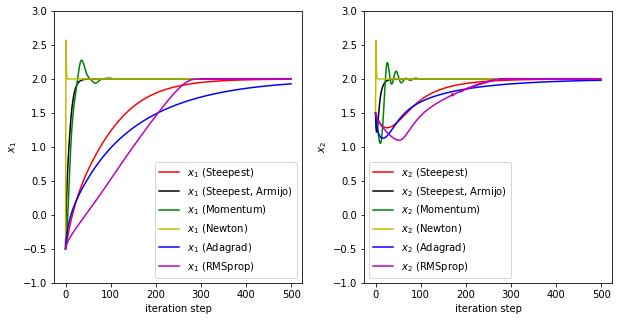

In [7]:
## plot x value of each step
fig = plt.figure(figsize = (10, 5))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
ax1 = fig.add_subplot(121)
ax1.set_xlabel("iteration step")
ax1.set_ylabel(r"$x_1$")
ax1.set_ylim([-1, 3])
ax1.plot(Xval_s[0], label = r"$x_1$ (Steepest)", c = "r")
ax1.plot(Xval_sl[0], label = r"$x_1$ (Steepest, Armijo)", c = "k")
ax1.plot(Xval_m[0], label = r"$x_1$ (Momentum)", c = "g")
ax1.plot(Xval_n[0], label = r"$x_1$ (Newton)", c = "y")
ax1.plot(Xval_a[0], label = r"$x_1$ (Adagrad)", c = "b")
ax1.plot(Xval_r[0], label = r"$x_1$ (RMSprop)", c = "m")
ax1.legend(loc = 'best')
ax2 = fig.add_subplot(122)
ax2.set_xlabel("iteration step")
ax2.set_ylabel(r"$x_2$")
ax2.set_ylim([-1, 3])
ax2.plot(Xval_s[1], label = r"$x_2$ (Steepest)", c = "r")
ax2.plot(Xval_sl[1], label = r"$x_2$ (Steepest, Armijo)", c = "k")
ax2.plot(Xval_m[1], label = r"$x_2$ (Momentum)", c = "g")
ax2.plot(Xval_n[1], label = r"$x_2$ (Newton)", c = "y")
ax2.plot(Xval_a[1], label = r"$x_2$ (Adagrad)", c = "b")
ax2.plot(Xval_r[1], label = r"$x_2$ (RMSprop)", c = "m")
ax2.legend(loc = 'best')
plt.show()

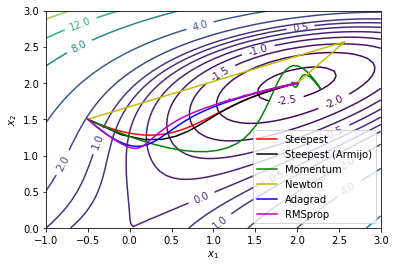

In [8]:
## draw function
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
x1 = np.linspace(-1, 3, 51)
x2 = np.linspace(0, 3, 51)
X1_grid, X2_grid = np.meshgrid(x1, x2)
value = f1fig(X1_grid, X2_grid)
cont = ax.contour(X1_grid, X2_grid, value, levels=[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0])
cont.clabel(fmt='%1.1f')
## plot
ax.plot(Xval_s[0], Xval_s[1], c = 'r', label = "Steepest")
ax.plot(Xval_sl[0], Xval_sl[1], c = 'k', label = "Steepest (Armijo)")
ax.plot(Xval_m[0], Xval_m[1], c = 'g', label = "Momentum")
ax.plot(Xval_n[0], Xval_n[1], c = 'y', label = "Newton")
ax.plot(Xval_a[0], Xval_a[1], c = 'b', label = "Adagrad")
ax.plot(Xval_r[0], Xval_r[1], c = 'm', label = "RMSprop")
ax.legend(loc = 'best')
plt.show()